In [1]:
#Clone the GitHub Repository
!git clone https://github.com/skokalj/RowanDLclassNEA.git

fatal: destination path 'RowanDLclassNEA' already exists and is not an empty directory.


In [2]:
%cd RowanDLclassNEA/

/home/ravuri/RowanDLclassNEA/NEUdata/RowanDLclassNEA


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import os

# Define a dataset class
class NEUDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))

    def __len__(self):
        return sum(len(files) for _, _, files in os.walk(self.root_dir))

    def __getitem__(self, idx):
        class_folder = os.path.join(self.root_dir, self.classes[idx % len(self.classes)])
        files = os.listdir(class_folder)

        # Check if the list of files is not empty
        if len(files) == 0:
            raise ValueError(f"No images found in {class_folder}")

        img_name = files[0]  # Take the first image for simplicity
        img_path = os.path.join(class_folder, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.classes.index(os.path.basename(class_folder))

        return image, label

# Define the model
class NEUClassifier(nn.Module):
    def __init__(self, num_classes):
        super(NEUClassifier, self).__init__()
        resnet = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.classifier = nn.Linear(resnet.fc.in_features, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
num_epochs = 50
batch_size = 32
learning_rate = 0.001

# Define transformations for data augmentation during training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the dataset and split into train and validation sets
dataset = NEUDataset(root_dir='NEUdata_split/Train', transform=train_transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
model = NEUClassifier(num_classes=len(dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_accuracy = correct / total

    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f},  Validation Accuracy: {val_accuracy:.4f}')

# Save the trained model
torch.save(model.state_dict(), 'neu_classifier.pth')
print("Model saved.")

/opt/pythonenvs/class_fall2023/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/pythonenvs/class_fall2023/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50], Loss: 0.5536, Accuracy: 0.9599,  Validation Accuracy: 0.9414
Epoch [2/50], Loss: 0.1678, Accuracy: 0.9606,  Validation Accuracy: 0.9568
Epoch [3/50], Loss: 0.0029, Accuracy: 0.9923,  Validation Accuracy: 0.9969
Epoch [4/50], Loss: 0.0237, Accuracy: 0.8434,  Validation Accuracy: 0.8333
Epoch [5/50], Loss: 0.0010, Accuracy: 0.9815,  Validation Accuracy: 0.9846
Epoch [6/50], Loss: 0.1476, Accuracy: 0.6381,  Validation Accuracy: 0.6111
Epoch [7/50], Loss: 0.3604, Accuracy: 0.9823,  Validation Accuracy: 0.9753
Epoch [8/50], Loss: 0.0017, Accuracy: 0.9753,  Validation Accuracy: 0.9660
Epoch [9/50], Loss: 0.0172, Accuracy: 0.9807,  Validation Accuracy: 0.9722
Epoch [10/50], Loss: 0.0132, Accuracy: 0.9861,  Validation Accuracy: 0.9907
Epoch [11/50], Loss: 0.0005, Accuracy: 0.9954,  Validation Accuracy: 0.9969
Epoch [12/50], Loss: 0.1935, Accuracy: 0.9961,  Validation Accuracy: 0.9969
Epoch [13/50], Loss: 0.0040, Accuracy: 0.9923,  Validation Accuracy: 0.9969
Epoch [14/50], Loss: 

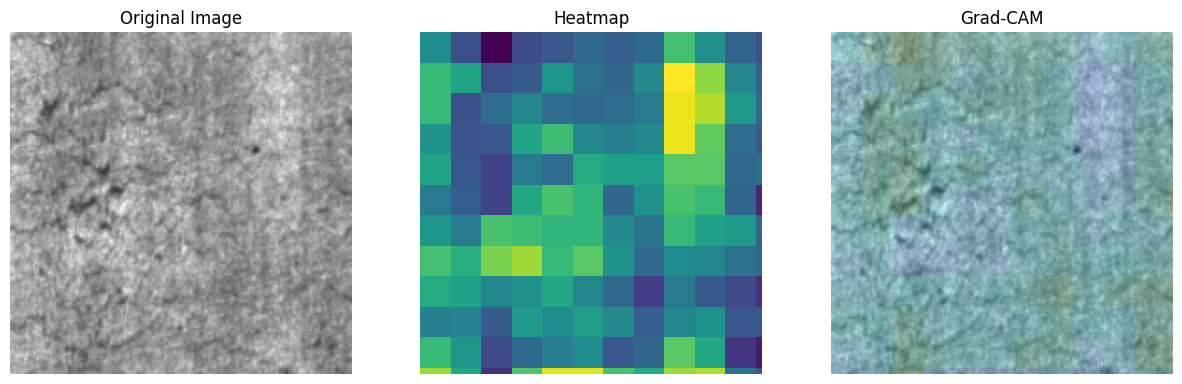

In [136]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Define the model
class NEUClassifier(nn.Module):
    def __init__(self, num_classes):
        super(NEUClassifier, self).__init__()
        resnet = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.classifier = nn.Linear(resnet.fc.in_features, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Load the pre-trained model
model = NEUClassifier(num_classes=6)
model.load_state_dict(torch.load('neu_classifier.pth'))
model.eval()

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the backward and forward hooks
gradients = None
activations = None

def backward_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

def forward_hook(module, input, output):
    global activations
    activations = output

# Identify the last convolutional layer in your model
last_conv_layer = None
for layer in reversed(list(model.features.children())):
    if isinstance(layer, nn.Conv2d):
        last_conv_layer = layer
        break

# Register hooks on the last convolutional layer
backward_hook = last_conv_layer.register_full_backward_hook(backward_hook)
forward_hook = last_conv_layer.register_forward_hook(forward_hook)

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

test_dataset = NEUDataset(root_dir='NEUdata_split/Test', transform=transform)

# Load an image from the test dataset
test_image, test_label = test_dataset[30]  # Assuming you want to use the first image from the test dataset
image = transforms.ToPILImage()(test_image)  # Convert the Tensor back to PIL Image

# Preprocess the image using the test_transform
img_tensor = transform(image).unsqueeze(0).to(device)

# Perform forward and backward pass
output = model(img_tensor)
output_scalar = output.max()  # Reduce the output to a scalar value
output_scalar.backward()

# Unregister hooks
backward_hook.remove()
forward_hook.remove()

# Pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3], keepdim=True)

# Weight the channels by corresponding gradients
for i in range(activations.size()[1]):
    activations[:, i, :, :] *= pooled_gradients[0, i, :, :]

# Average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# ReLU on top of the heatmap
heatmap = F.relu(heatmap)

# Normalize the heatmap
heatmap /= torch.max(heatmap)

# Convert to NumPy array
heatmap_np = heatmap.detach().cpu().numpy()

# Resize the heatmap to match the original image size
heatmap_resized = cv2.resize(heatmap_np, (image.width, image.height))

# Convert heatmap to the range [0, 255]
heatmap_rescaled = (heatmap_resized * 255).astype(np.uint8)

# Create a grid of squares based on heatmap values
heatmap_colored = np.zeros_like(heatmap_np, dtype=np.uint8)
size = 10  # Adjust the square size as needed

for i in range(0, heatmap_colored.shape[0], size):
    for j in range(0, heatmap_colored.shape[1], size):
        value = torch.mean(heatmap[i:i+size, j:j+size])
        heatmap_colored[i:i+size, j:j+size] = int(value * 255)

# Convert the heatmap to the same data type and number of channels as the original image
heatmap= cv2.applyColorMap(heatmap_colored, cv2.COLORMAP_JET)

# Resize the heatmap to match the original image size
heatmap_resized = cv2.resize(heatmap, (image.width, image.height))
heatmap_resized = heatmap_resized.astype(np.uint8)

# superimposed the heatmap with the original image
super_imposed_img = cv2.addWeighted(np.array(image), 0.8, heatmap_resized, 0.2, 0)

# Plot side by side
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.axis('off')
plt.title('Original Image')

# Heatmap 
plt.subplot(1, 3, 2)
plt.imshow(heatmap_colored, cmap='viridis')  # Use any colormap you prefer
plt.axis('off')
plt.title('Heatmap')

# Grad-CAM 
plt.subplot(1, 3, 3)
plt.imshow(super_imposed_img)
plt.axis('off')
plt.title('Grad-CAM')

plt.show()